# Regression Prep

The following notebook prepares our cleaned building data to be used for a regression analysis that predicts the number of units in a building based on a building's volume and potentially it's sqft. The original `building` geopackage comes from cleaning done in the ElectriGrid repository, and combines data sourced from Zillow and Microsoft Building Footprint.

**Steps:**
1. Find base area of each building, based on geometry (and save as column)
2. Multiply base area by building height, and save as `volume` variable
3. Separate observations with and without unit data
4. Evaluate `sqft_type` variable and its unique values. What does it mean, and can it help us in our regression?

In [46]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [8]:
fp = os.path.join('data', 'building_clean.gpkg')
building = gpd.read_file(fp)

In [11]:
# remind ourselves of the data
building.head(3)

,height,var,region,index_right,type,room,heat,cool,own,unit,value,sqft_type,sqft,GEOID,ID,geometry
0,4.743917,0.886769,USA,7936689,Single,3.0,None,None,O,1.0,289974.0,living,1380.0,06073010104,8307781,"POLYGON ((-117.09581 32.56566, -117.09581 32.5..."
1,3.584368,0.209780,USA,7936684,Single,4.0,None,None,O,1.0,285423.0,living,2187.0,06073010104,8307776,"POLYGON ((-117.09666 32.56567, -117.09666 32.5..."
2,6.331801,1.570812,USA,7936688,Single,4.0,None,None,O,1.0,152338.0,living,1546.0,06073010104,8307780,"POLYGON ((-117.09598 32.56570, -117.09598 32.5..."


## Finding Volume

In [10]:
# confirm what current crs is 
building.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# reproject data frame to crs with meters as units
building_m = building.to_crs("EPSG:6933")

In [18]:
# find and create column from polygon area
building_m['area_m2'] = building_m.geometry.area

# rename height column to be clear about units
building_m.rename(columns={"height":"height_m"}, inplace = True)

building_m.head(2)

,height_m,var,region,index_right,type,room,heat,cool,own,unit,value,sqft_type,sqft,GEOID,ID,geometry,area,area_m2
0,4.743917,0.886769,USA,7936689,Single,3.0,None,None,O,1.0,289974.0,living,1380.0,06073010104,8307781,"POLYGON ((-11298139.310 3939502.166, -11298139...",289.335582,289.335582
1,3.584368,0.209780,USA,7936684,Single,4.0,None,None,O,1.0,285423.0,living,2187.0,06073010104,8307776,"POLYGON ((-11298221.031 3939503.395, -11298221...",283.671448,283.671448


In [20]:
# create volume column
building_m['volume_m3'] = building_m['area_m2'] * building_m['height_m']

building_m.head(2)

,height_m,var,region,index_right,type,room,heat,cool,own,unit,value,sqft_type,sqft,GEOID,ID,geometry,area,area_m2,volume_m3
0,4.743917,0.886769,USA,7936689,Single,3.0,None,None,O,1.0,289974.0,living,1380.0,06073010104,8307781,"POLYGON ((-11298139.310 3939502.166, -11298139...",289.335582,289.335582,1372.584121
1,3.584368,0.209780,USA,7936684,Single,4.0,None,None,O,1.0,285423.0,living,2187.0,06073010104,8307776,"POLYGON ((-11298221.031 3939503.395, -11298221...",283.671448,283.671448,1016.782790


## Separate Data

In [31]:
# explore number of rows that don't have unit data -- it's a lot
building_m['unit'].isna().sum()

1873604

In [35]:
# keep only observations with unit data
building_m_unit_data = building_m[~building_m['unit'].isna()]

# confirm operation worked
building_m_unit_data['unit'].isna().sum()

0

### What is the distribution of unit type?

In [52]:
building_m_unit_data['unit'].describe()

count    2.539192e+06
mean     1.576839e+00
std      5.289147e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.130000e+02
Name: unit, dtype: float64

In [ ]:
# plot number units to see it's distribution -- will help us determine which stat model to use
# building_m_unit_data['unit'].plot(kind='bar')

<Axes: ylabel='Density'>

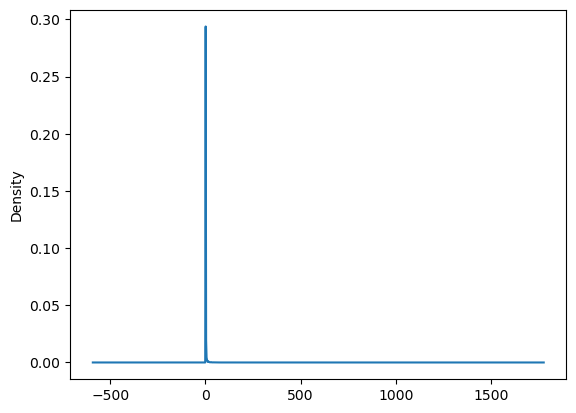

In [40]:
building_m_unit_data['unit'].plot.density()

In [44]:
building_m_unit_data.shape

(2576659, 19)

(0.0, 100.0)

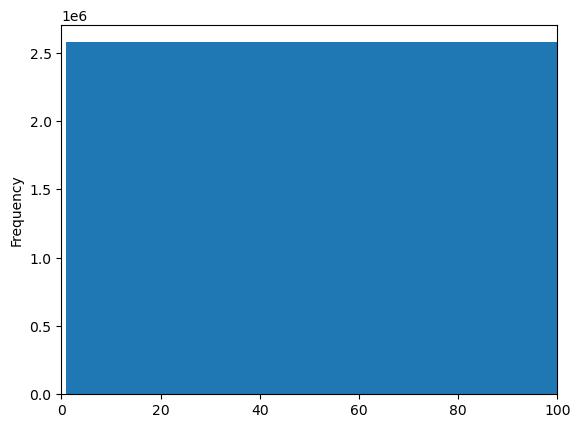

In [47]:
building_m_unit_data['unit'].plot(kind = 'hist')
plt.xlim(0,100)

In [48]:
building_m_unit_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2576659 entries, 0 to 4449793
Data columns (total 19 columns):
 #   Column       Dtype   
---  ------       -----   
 0   height_m     float64 
 1   var          float64 
 2   region       object  
 3   index_right  int64   
 4   type         object  
 5   room         float64 
 6   heat         object  
 7   cool         object  
 8   own          object  
 9   unit         float64 
 10  value        float64 
 11  sqft_type    object  
 12  sqft         float64 
 13  GEOID        object  
 14  ID           int64   
 15  geometry     geometry
 16  area         float64 
 17  area_m2      float64 
 18  volume_m3    float64 
dtypes: float64(9), geometry(1), int64(2), object(7)
memory usage: 393.2+ MB


## `sqft_type` and `sqft` investigation

In [49]:
# view unique values 
building_m['sqft_type'].unique()

array(['living', None, 'others'], dtype=object)

In [50]:
# keep only living 
building_m_unit_data = building_m_unit_data[building_m_unit_data['sqft_type'] == 'living']

<Axes: xlabel='unit', ylabel='sqft'>

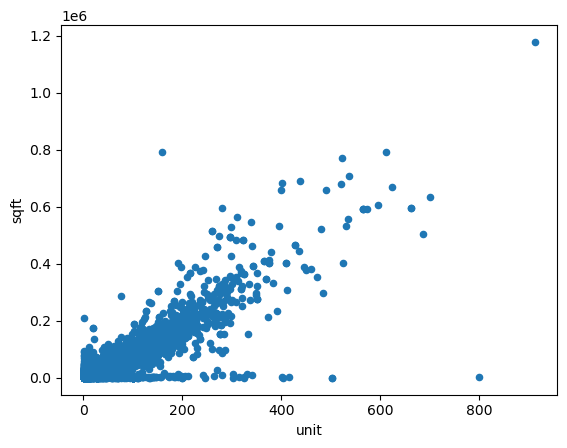

In [51]:
# are sqft and unit correlated? --> will help answer what sqft actually represents (area per unit or per building)
building_m_unit_data.plot(kind='scatter',
              x='unit', 
              y='sqft')

The column `sqft` seems to represent **total** living area!